This file is the code infrastructure to follow along with the experiment from the paper.

In [2]:
from matplotlib.colors import ListedColormap
from time import sleep
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
class BML:
    def __init__(self, n, m, rush_start, rush_l):
        """
        Sets up an empty grid for a biham-middleton-levine model.
        
        args:
            n: int length of grid
            m: int width of grid     
        """
        self.array = np.zeros((n, m), dtype=np.int8)
        self.n = n
        self.m = m
        self.cmap = ListedColormap(['white', '#95d0fc', '#ff474c'])
        self.t = 0
        self.free_flow = []
        self.rush_start = rush_start
        self.rush_l = rush_l
        self.rush_hour = False
        self.post_rush = False
        self.densities = []

    def start_small(self):
        """
        A preset starting config with 1 blue cell and 2 red cells.
        """
        self.array[0, self.m//2] = 1
        self.array[0, self.m//2 +1] = 2
        self.array[self.n//2, 0] = 2

    def start_density(self, density):
        """
        Randomly adds red and blue cells throughout a grid to a specific density.

        args:
            density: an int between 0 anf 1 to determine how full the grid is
        """
        self.density = density
        self.array = np.random.choice([0,1,2], size=(self.n,self.m), p=[1-density, density/2, density/2])


    def step(self, color):
        """
        Move all blue cells one over to the right if the next cell is empty.

            args: 
                color: an int, 1 or 2, representing the color that is stepping
        """
        if color == 2:
            self.array = self.array.T
        jams = False
        for row in self.array:
            cell_0 = row[0]
            i = 0
            
            while i  < len(row):
                if i == len(row) - 1:
                    if (row[i] == color or self.rush_hour) and cell_0 == 0:
                        row[i] = 0
                        if not (self.post_rush and np.random.choice([True, False])):
                            row[0] = color
                    elif row[i] == color and cell_0 != 0:
                        jams = True
                    break
                else:
                    if row[i] == color and row[i+1] == 0:
                        row[i] = 0
                        row[i+1] = color
                        i += 2
                    elif row[i] == color and row[i+1] != 0:
                        jams = True
                        i += 1
                    else:
                      i+=1
        if jams == False and self.t > self.rush_start + self.rush_l:
            self.free_flow.append(self.t)
        if color == 2:
            self.array = self.array.T

    def loop(self, steps=1):
        """
        Create complete cycles of blue and then red cell moving.

        args:
            steps: an int of the number of cycles
        """
        for _ in range(steps):
            self.step(1)
            self.step(2) 
            self.t += 1
            self.rush_hour = self.t > self.rush_start and self.t < self.rush_start + self.rush_l
            self.post_rush =  self.t > self.rush_start + self.rush_l and sum(sum(self.array)) > 1.5 * self.density * self.n * self.m
            if self.rush_hour:
                self.densities.append(sum(sum(self.array))/(1.5*self.n*self.m))
            

    def animate(self, frames=1, interval=None):
        """
        Animates the cycles.

        args:
            frames: an int of the number of frames
            interval: an int of the time to put between frames
        """
        plt.figure()
        try:
            for _ in range(frames-1):
                self.draw()
                plt.show()
                if interval:
                    sleep(interval)
                self.loop()
                clear_output(wait=True)
            self.draw()
            plt.show()
        except KeyboardInterrupt:
            pass

    def draw(self, start=0, end=None):
      """
      Draw the current grid.

      args:
        start: an int index to represent where to start displaying
        end: an int index to represent where to stop displaying
      """
      a = self.array[:, start:end]
      plt.imshow(a, cmap=self.cmap, alpha=0.7)

      # turn off axis tick marks
      plt.xticks([])
      plt.yticks([])


In [9]:
def measure(density, loops, depth, l):
    flow_times = []
    speed_counter = 0
    densities = [0]
    for _ in range(loops):
        bml = BML(250, 250, 50, l)
        bml.start_density(density)
        bml.loop(depth)
        found = False
        if (len(densities)):
            densities = np.add(densities, bml.densities)
        else: 
            densities = bml.densities

        if len(bml.free_flow) > 0:
            found = True
            flow_times.append(bml.free_flow[0])
        if not found:
            speed_counter += 1

    if len(flow_times):
        avg = sum(flow_times) / len(flow_times)
    else:
        avg = 0
    return avg, speed_counter, np.divide(densities, loops)

measure(.5, 2, 100, 10)


(0,
 2,
 array([0.4984    , 0.5043    , 0.5047    , 0.51026667, 0.51113333,
        0.5156    , 0.51636667, 0.51986667, 0.5209    ]))

In [16]:
# size 100
lengths = [i * 5 for i in range(2, 40)]
stop = []
all_dens = []

for i in range(len(lengths)):
    avg, speed_counter, ds = measure(0.1, 10, 1000, lengths[i])
    stop.append(avg - lengths[i])
    all_dens.append(ds)

print(stop)

[344.8, 307.0, 345.5, 327.6, 359.8, 355.4, 402.3, 368.0, 392.1, 404.5, 380.0, 428.5, 404.7, 416.2, 460.5, 450.1, 458.4, 467.0, 462.5, 507.29999999999995, 501.70000000000005, 496.5, 532.2, 510.2222222222222, 589.6, 574.0, 597.0, 627.75, 648.2222222222222, 620.875, 613.75, 575.25, 654.2857142857143, 683.2, 648.4, 689.4, 725.0, 718.75]


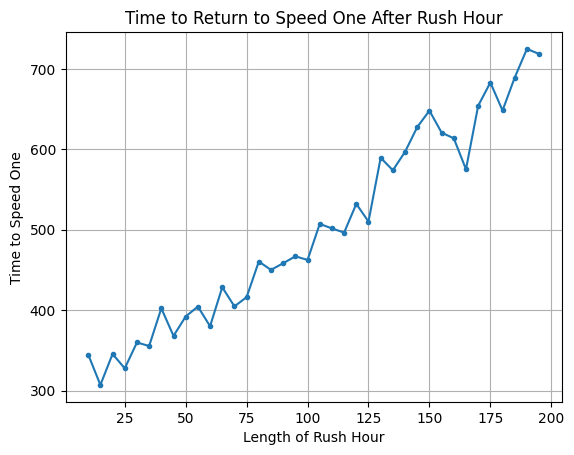

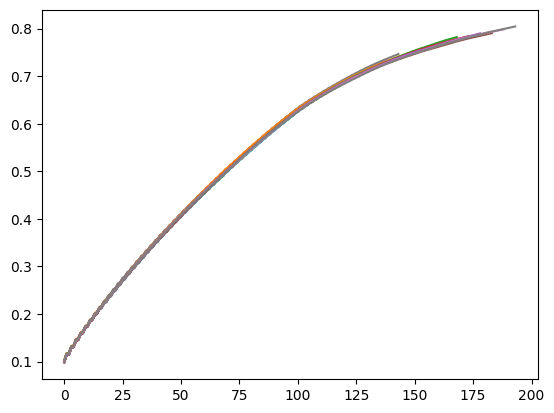

In [27]:
data = [344.8, 307.0, 345.5, 327.6, 359.8, 355.4, 402.3, 368.0, 392.1, 404.5, 380.0, 428.5, 404.7, 416.2, 460.5, 450.1, 458.4, 467.0, 462.5, 507.29999999999995, 501.70000000000005, 496.5, 532.2, 510.2222222222222, 589.6, 574.0, 597.0, 627.75, 648.2222222222222, 620.875, 613.75, 575.25, 654.2857142857143, 683.2, 648.4, 689.4, 725.0, 718.75]
# Plotting the lists
plt.plot(lengths, stop, marker='.')

# Adding labels and title
plt.xlabel('Length of Rush Hour')
plt.ylabel('Time to Speed One')
plt.title('Time to Return to Speed One After Rush Hour')

# Display the plot
plt.grid(True)
plt.show()

for row in all_dens:
    plt.plot(row)
